<a href="https://colab.research.google.com/github/einsteinxx/UCLA_BIOENG596_2021_SUMMER/blob/main/DBT_patch_selection2_ph2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc  #debug memory leaks in matplotlib
import csv #read in description files
import random #used to select random slice for patches
import cv2

#GLCM usage
import scipy
from scipy import ndimage
from skimage.feature import greycomatrix, greycoprops

#Gabor filter usage
from skimage.filters import gabor_kernel
from skimage.filters import gabor

from google.colab.patches import cv2_imshow
#
# Read Data from google drive
#
from google.colab import drive #for loading gdrive data
from google.colab import files

# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug
!pip3 install -q pickle5

import pydicom #to read dicom files
from pydicom import dcmread
import pickle5 as pickle; #generic storage of image arra

# Load data from google drive
#

drive.mount('/content/gdrive')

data_dir = '/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/DICOM2RAW/TRAINING' #matrix img data
#'/content/gdrive/My Drive/DBT_DATA/IMG_ARRAYS'
 
csv_dir = '/content/gdrive/My Drive/DBTex2/'

use_glcm_patches = 0
use_gabor_patches = 1

if (use_glcm_patches == 1):
    top_dir = '/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GLCM'
    #output patch save dir
    patch_normal_dir = '/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GLCM/NORMAL'
    patch_actionable_dir = '/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GLCM/ACTIONABLE' 
    patch_benign_dir = '/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GLCM/BENIGN'
    patch_cancer_dir = '/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GLCM/CANCER'  
elif (use_gabor_patches == 1):
    top_dir = '/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR'
    #output patch save dir
    patch_normal_dir = '/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR/NORMAL'
    patch_actionable_dir = '/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR/ACTIONABLE' 
    patch_benign_dir = '/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR/BENIGN'
    patch_cancer_dir = '/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR/CANCER'   
else:
    top_dir = '/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES'
    #output patch save dir
    patch_normal_dir = '/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES/NORMAL'
    patch_actionable_dir = '/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES/ACTIONABLE' 
    patch_benign_dir = '/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES/BENIGN'
    patch_cancer_dir = '/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES/CANCER'


gfrequency1 = 0.08 #gabor filter frequencies
gfrequency2 = 0.4
theta = 0.0 #radians
create_cancer_patches = 1 #1 = make cancer/benign patches, 0 = off
create_normal_patches = 1

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
def calc_GLCM(patch,distance_in = 5, angle_in = 0, levels_in = 256):
    
    xs=[]
    ys=[]
    glcm = greycomatrix(patch, distances=[distance_in], angles=[angle_in], levels=levels_in,
                        symmetric=True, normed=True)
    xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(greycoprops(glcm, 'correlation')[0, 0])

    return glcm, xs,ys

In [3]:
def calc_Gabor(image, frequency=0.6, theta =0.0):
    filt_real, filt_imag=gabor(image, frequency,theta)
    return filt_real, filt_imag

In [4]:
def get_csv_data(filename):
    fields = []
    rows = []

    # reading csv file
    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)
        
        # extracting field names through first row
        fields = next(csvreader)

        # extracting each data row one by one
        for row in csvreader:
            rows.append(row)


        # lines present
        print("found rows: %d"%(csvreader.line_num))
    return fields, rows

In [5]:
def get_ROI(patient_id, patient_uid,view_type, boxes_rows):
    #get the corners of the annotated box
    #slice, x,y,width, height
    box_info = []
    for ii in boxes_rows:
        if (patient_id in ii[0]):
            if (view_type in ii[2]):# and (patient_uid in ii[1]):
                #print('found box data')
                box_info.append(ii[4:9])
                break
    if(len(box_info) < 1):
        ## CHECK TO SEE IF THIS IS CANCER OR HAS A BOX. CLEAR CASES WON'T HAVE BOXES
        print('!!!!!! WARNING. BOUNDING BOXES EMPTY')
        print(patient_id, patient_uid, view_type)
    return box_info

In [6]:
def choose_tissue_area(img_data, patch_x,patch_y,slice_selection = 2,debug=0):


    if (debug == 1):  print('slice chosen is ',slice_selection)
    slice_data = img_data[slice_selection,:,:]

    # convert the grayscale image to binary image
    #look for anything >1 and assign that a 1 value. Expectation is that 
    #any area without attenuation will have 0 value -- adjust the lower val
    #if blurred areas need to be brought in. Last 0 is just the default
    #threshold type
    ret,thresh = cv2.threshold(slice_data,1,1,0)


    # calculate moments of binary image
    M = cv2.moments(thresh)
    # calculate x,y coordinate of center
    center_x = int(M["m10"] / M["m00"])
    center_y = int(M["m01"] / M["m00"])
    if (debug == 1):  print('center is ', center_x,center_y)


    # create a patch centered at the centroid location
    patch_lr = center_x-int(patch_x/2),center_x+int(patch_x/2)
    patch_tb = center_y-int(patch_y/2),center_y+int(patch_y/2)
    #        indices = np.where(slice_data!= [0])
    #        coordinates = zip(indices[0], indices[1])

    slice_lower = slice_selection -1
    slice_upper = slice_selection +2
    patch_img = img_data[slice_lower:slice_upper,patch_tb[0]:patch_tb[1],
                         patch_lr[0]:patch_lr[1]]

    total_slices = np.shape(patch_img)
    original_shape = np.shape(img_data)
    assert (total_slices[0] == 3), \
        "Slice was not 3 in Normal create{},{},{}--{}".format(total_slices, \
                                                          slice_lower, slice_upper, original_shape)

    if debug == 1:
        plt.figure()
        plt.imshow(thresh,cmap='bone') #img_data[slice_selection,:,:],cmap='bone')
        plt.text(center_x,center_y,'.')
        plt.text(patch_lr[0],patch_tb[0],'O')
        plt.colorbar()


        #### Draw annotation box
        xcorner = int(patch_lr[0])
        ycorner = int(patch_tb[0])
        xwidth = int(244)
        yheight = int(244)

        rect = patches.Rectangle((xcorner,ycorner),xwidth,yheight,linewidth=2,edgecolor='r',facecolor='none')
        # Get the current reference
        ax = plt.gca()
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.show()


    return patch_img,center_x,center_y


In [7]:
#READ CSV FILES
#pull out the box information and label info
csv_list = os.listdir(csv_dir)

for csv_file in csv_list:
    filename = os.path.join(csv_dir,csv_file)
    if (os.path.isdir(filename) == 1):
        #skip any directories found in list
        continue
    if ('path' in csv_file):
        path_fields, path_rows = get_csv_data(filename)
    elif('labels' in csv_file):
        label_fields, label_rows = get_csv_data(filename)        
    elif('boxes' in csv_file):
        boxes_fields, boxes_rows = get_csv_data(filename)
    else:
        print('Non-archive file found ',filename)

print('box shape is ',np.shape(boxes_rows))

#get average box dimensions
xdim =[]
ydim = []
for ii in boxes_rows:
    xdim.append(np.uint(ii[7]))
    ydim.append(np.uint(ii[8]))

average_x = sum(xdim)/len(xdim)
average_y = sum(ydim)/len(ydim)
print('average ROI x and y dimensions are: ',average_x,average_y)

####
num_slices = np.double(np.array(boxes_rows)[:,[11]])
print('min slices, max slices = ',np.amin(num_slices), np.amax(num_slices))


found rows: 19149
found rows: 19149
found rows: 225
Non-archive file found  /content/gdrive/My Drive/DBTex2/saved_diretories.pckl
box shape is  (224, 12)
average ROI x and y dimensions are:  243.25446428571428 238.02678571428572
min slices, max slices =  24.0 114.0


In [8]:
def randomize_patches(islice, irows, icols,slice_selection, x_corner, y_corner, x_width,y_height):
    #take in the annotation area and move around that to get a new patch


    '''
    slice_selection = int(box_info[0][0])
    x_corner = int(box_info[0][1])
    y_corner = int(box_info[0][2])
    x_width = int(box_info[0][3])
    y_height = int(box_info[0][4])
    '''

    #if (len(box_info) < 5):
    #    print(box_info)
    row_corner = y_corner
    col_corner = x_corner
    box_slice = slice_selection

    #Set the amount the random point can extend beyond the original patch area
    roi_delta = 0.1
    patch_size= 244
    patch_gap = patch_size * roi_delta


    #This is the allowed range of box centers, all within the given ROI
    #selectable_col = range(box_info[4],box_info[4]+box_info[5])
    col_limit = x_corner + x_width  #the column range in image (pixels)
    row_limit = y_corner + y_height #the row range in image (pixels)
    #selectable_row = range(box_info[2],box_info[2]+box_info[3])


    box_safe =0 #the number of boxes within the RetinaNet boundary
    box_corners = []
    counter = 0
    while ((box_safe < 5) and (counter < 1e4)):
        #loop until you get enough boxes to satisfy box_safe condition
        #or until you hit 1000, which means something is not right
        counter +=1 #safeguard for while

        #generate a random point within or some % outside of the box limits
        lowrow = row_corner- patch_gap
        highrow = row_limit + patch_gap
        assert(lowrow < highrow),print('Failure with random int ',lowrow,highrow)
        row_corner=np.random.randint(lowrow,highrow )
        
        lowcol = col_corner- patch_gap
        highcol = col_limit + patch_gap

        #debug if the random int problem shows
        assert(lowcol < highcol),print('Failure with random int ',lowcol,highcol)
        col_corner=np.random.randint(lowcol,highcol)
        
        #check to see if this new corner extends beyond any image end
        if ((row_corner < 0) or (col_corner <0) or 
            (((row_corner + patch_y) > irows) or ((col_corner + patch_x) > icols))):
            #box will extend off image boundary
            #don't let this new bounding box through, redo it
            #print('UNSAFE BOX--ADJUSTING ',row_corner,col_corner)
            #pass




            #check to see if our patch size doesn't go past boundary
            if  ((col_corner + patch_x)> icols):
                diff = (col_corner + patch_x) - icols
                col_corner = col_corner - diff
                print('adjusting x limits of ', col_corner)
            
            if  ((row_corner + patch_y)> irows):
                diff = (row_corner + patch_y) - irows
                row_corner = row_corner - diff
                print('adjusting y limits of ', col_corner)
            box_safe += 1
            box_corners.append([row_corner, col_corner])
        else: #This box is safe, use it for calculations
            box_safe += 1
            box_corners.append([row_corner, col_corner])

    if (len(box_corners) != 5):
        print('Failed to find enough sample boxes')

    slice_lower = box_slice - 1
    slice_upper = box_slice + 1


    #build patches from random boxes
    data = {}
    for ii in range(0,1): #len(box_corners)):
        row_lims_low, row_lims_high = box_corners[ii][0],box_corners[ii][0]+patch_y
        col_lims_low, col_lims_high = box_corners[ii][1],box_corners[ii][1]+patch_x
        #patch_img = img_data[slice_lower:slice_upper+1,row_lims_low:row_lims_high,col_lims_low:col_lims_high]


        #output90, output180, output270, outputflip = create_augmented_data(image,flip = 1,rot90=1,rot180=1,rot270=1)
    return row_lims_low, row_lims_high, col_lims_low, col_lims_high

In [9]:
def create_augmented_data(image_data,output_filename,main_dir,flip,rot90,rot180,rot270,
                          use_glcm =0, use_gabor =0, frequency0=0.3,frequency1=0.6,theta=0.0):
    #flip and rotate the data to make new data files
        #save patch to a file
    patchx = 244
    patchy = 244
    output90 = np.zeros([3,patchx,patchy])
    output180 = np.zeros([3,patchx,patchy])
    output270 = np.zeros([3,patchx,patchy])
    outputflip = np.zeros([3,patchx,patchy])

    #print(np.shape(image_data), np.shape(output90))

    for ii in range(0,np.shape(image_data)[0]):
        if ((use_glcm ==1) and (ii != 1)and (use_gabor == 0)):
            #fill in secondary slices with GLCM data
            middle_image = np.uint16(image_data[1,:,:]/65535.0*243) #to lower gray level #
            print('middle image type =',type(middle_image[100,100]))
            image90 = np.rot90(middle_image)
            image_90,xs,xy = calc_GLCM(image90,distance_in = 10, angle_in = 0, levels_in = 244)
            ###### 180 ROTATION
            image180 = np.rot90(middle_image,k=2)
            image_180,xs,xy = calc_GLCM(image180,distance_in = 10, angle_in = 0, levels_in = 244)


            image270 = np.rot90(middle_image,k=3)
            image_270,xs,xy = calc_GLCM(image270,distance_in = 10, angle_in = 0, levels_in = 244)
            ###### FLIP
            imageflip = np.fliplr(middle_image)
            filt_real, filt_imag=calc_Gabor(image_flip, theta,frequency=frequency0)
            image_flip = file_real
            #print(np.shape(image_90))
            #print(np.shape(imageflip))
            #imageflip,xs,xy = calc_GLCM(imageflip,distance_in = 10, angle_in = 0, levels_in = 244)


            
            output90[ii,:,:] = np.squeeze(image90[:,:])*65535
            output180[ii,:,:] = np.squeeze(image180[:,:])*65535
            output270[ii,:,:] = np.squeeze(image270[:,:])*65535
            outputflip[ii,:,:] = np.squeeze(imageflip[:,:])*65535
        elif ((use_glcm == 0 ) and (use_gabor == 1) and (ii != 1)):
            #fill in one slice with glcm and one with gabor
            if (ii == 0):
                frequency = frequency0
            else:
                frequency = frequency1

            middle_image = image_data[1,:,:] #to lower gray level #
            print('middle image type =',type(middle_image[100,100]))

            image90 = np.rot90(middle_image)
            filt_real, filt_imag=calc_Gabor(image90, frequency,theta)
            image90g = filt_real

            ###### 180 ROTATION
            image180 = np.rot90(middle_image,k=2)
            filt_real, filt_imag=calc_Gabor(image180, frequency,theta)
            image180g = filt_real

            ###### 270 ROTATION
            image270 = np.rot90(middle_image,k=3)
            filt_real, filt_imag=calc_Gabor(image270, frequency,theta)
            image270g = filt_real

            ###### FLIP
            imageflip = np.fliplr(middle_image)
            filt_real, filt_imag=calc_Gabor(imageflip, frequency,theta)
            imageflipg = filt_real



            
            output90[ii,:,:] = image90g[:,:]
            output180[ii,:,:] = image180g[:,:]
            output270[ii,:,:] = image270g[:,:]
            outputflip[ii,:,:] = imageflipg[:,:]           

        else: #keep center slice and only apply rotation
            image90 = np.rot90(image_data[ii,:,:])
            image180 = np.rot90(image_data[ii,:,:],k=2)
            image270 = np.rot90(image_data[ii,:,:],k=3)
            imageflip = np.fliplr(image_data[ii,:,:])
            
            output90[ii,:,:] = image90
            output180[ii,:,:] = image180
            output270[ii,:,:] = image270
            outputflip[ii,:,:] = imageflip
    #plt.imshow(output90[1,:,:])
    fig, axs = plt.subplots(1,3,figsize = (4, 4))
    axs[0].imshow(outputflip[0,:,:])
    axs[1].imshow(outputflip[1,:,:])
    axs[2].imshow(outputflip[2,:,:])
    #axs[4].imshow(a4_data[1,:,:])
    axs[0].title.set_text('Slice0')
    axs[1].title.set_text('Slice1')
    axs[2].title.set_text('Slice2')
    #axs[3].title.set_text('270 degrees')
    #axs[4].title.set_text('Horizontal Flip')


    names=os.path.splitext(output_filename)
    for ii in ['ROT90','ROT180','ROT270','FLIPH']:
        fname = names[0] + '_' + ii + '.pickle'
        img_file_pickle = os.path.join(main_dir,fname)
        if ((ii == 'ROT90') and (rot90 == 1)):
            patch_img = output90
        elif ((ii == 'ROT180') and (rot180==1)):
            patch_img = output180
        elif ((ii == 'ROT270') and (rot270==1)):
            patch_img = output270
        elif ((ii == 'FLIPH') and (flip == 1)):
            patch_img = outputflip
        else:
            #print('!!! Warning, incorrect augment type found: ',ii)
            continue
        mean_value = np.mean(patch_img)
        if ( (mean_value < 1)): 
            #this is likely an empty patch, dump it overboard
            print('-----------------------in augmentation, found empty image. Discarding')
            continue
        else:
            #this patch has "something" so keep it
            pickle.dump(patch_img, open( img_file_pickle, "wb" ),protocol=5 )
            print(fname)


In [ ]:
raw_files = os.listdir(data_dir)
print('found #files: ',len(raw_files))

start_point  = -1
patch_x = 244
patch_y = 244
for counter,filename in enumerate(raw_files):
    #if (counter > 10):
    #    break
    
    #load full array
    full_filename = os.path.join(data_dir,filename)
    
    if (('Benign' in filename) or ('Cancer' in filename)): 
        #only want to run on normal/actionable labels  
        print(full_filename)
        img_data = pickle.load( open( full_filename, "rb" ) )
        dims = np.shape(img_data)
        print(dims)
        output_filename = 'test'
        img_data = img_data[0:3,1000:1244,1000:1244]
        print('img_data shape is ',np.shape(img_data))
        #create_augmented_data(img_data,output_filename,flip = 1,rot90=1,rot180=1,rot270=1)
        break


found #files:  11349
/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/DICOM2RAW/TRAINING/DBT-P02380_DBT-S01233_lmlo_Benign.pickle
(58, 2457, 1890)
img_data shape is  (3, 244, 244)


In [ ]:
#quick view of original cancer patch and variants
if (0):
    a1= '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/CANCER/DBT-P01110_DBT-S04109_lcc_Cancer_s34_cx484_cy835_244_244_ROT90.pickle'
    a2='/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/CANCER/DBT-P01110_DBT-S04109_lcc_Cancer_s34_cx484_cy835_244_244_ROT180.pickle'
    a3='/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/CANCER/DBT-P01110_DBT-S04109_lcc_Cancer_s34_cx484_cy835_244_244_ROT270.pickle'
    a4='/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/CANCER/DBT-P01110_DBT-S04109_lcc_Cancer_s34_cx484_cy835_244_244_FLIPH.pickle'
    original_file = '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/CANCER/DBT-P01110_DBT-S04109_lcc_Cancer_s34_cx484_cy835_244_244.pickle'


    img_data = pickle.load( open( original_file, "rb" ) )
    a1_data = pickle.load( open( a1, "rb" ) )
    a2_data = pickle.load( open( a2, "rb" ) )
    a3_data = pickle.load( open( a3, "rb" ) )
    a4_data = pickle.load( open( a4, "rb" ) )


    fig, axs = plt.subplots(1,5,figsize = (20, 10))
    #fig.suptitle('DBT-P01110 LCC CANCER slice34')
    axs[0].imshow(img_data[1,:,:])

    axs[1].imshow(a1_data[1,:,:])
    axs[2].imshow(a2_data[1,:,:])
    axs[3].imshow(a3_data[1,:,:])
    axs[4].imshow(a4_data[1,:,:])
    axs[0].title.set_text('Original')
    axs[1].title.set_text('90 degrees')
    axs[2].title.set_text('180 degrees')
    axs[3].title.set_text('270 degrees')
    axs[4].title.set_text('Horizontal Flip')



In [ ]:

if (0):
    #test removing directories
    print(patch_normal_dir)
    #!ls gdrive/My\ Drive/DBT_WORKSPACE/TRAINING_PATCHES/NORMAL
    import shutil
    if (os.path.exists(patch_normal_dir) == 1):
        print('normal patch dir found')
        shutil.rmtree(patch_normal_dir)
    else:
        print('no normal dir found')
    os.mkdir(patch_normal_dir)

In [ ]:
################################################################################
# GENERATE SAMPLE PATCHES FOR NORMAL DATA
################################################################################
use_augments = 1  #Disable additional augmented data
if (create_normal_patches == 1):
    raw_files = os.listdir(data_dir)
    print('found #files: ',len(raw_files))

    #check to see if output directories are present
    for ii in (patch_normal_dir,patch_actionable_dir):
        if (os.path.exists(ii)):
            print('Existing directory: ',ii)
        else:
            os.mkdir(ii)

    start_point  = -1 #-1
    patch_x = 244
    patch_y = 244
    for counter,filename in enumerate(raw_files):
        if (counter < start_point):
            continue


        #load full array
        full_filename = os.path.join(data_dir,filename)
        if (('Normal' in filename) or ('Actionable' in filename)): 
            #only want to run on normal/actionable labels   
            try:
                print(full_filename)
                #if ('Normal' in filename):
                #    continue
                img_data = pickle.load( open( full_filename, "rb" ) )
                dims = np.shape(img_data)
            except:
                print('Empty raw file pickle: ',full_filename)
                continue
        else:
            print('SKIPPING non-Normal file')
            continue


        #get a random slice
        number_slices = np.shape(img_data)[0]
        #don't allow edge slices to be chosen
        slice_selection = random.randint(1, number_slices-2)

        num_slices, num_rows, num_cols = np.shape(img_data)

        #
        # Create patches, with a random set chosen from the annotation area. For 
        # cases where Normal greatly outnumbers the other classes, toggle the random
        # patches off
        #
        normal_random_patches = 0 #turn off or on 

        if (normal_random_patches == 1):
            num_norm_patches = 5 #chosen number of random patches to make
        else:
            num_norm_patches = 1


        for ii in range(0,num_norm_patches):

            _,cx,cy = choose_tissue_area(img_data, patch_x,patch_y,
                                slice_selection = slice_selection,
                                debug=0)
            x_corner_box = cx 
            y_corner_box = cy 
            x_width = 244
            y_height = 244
            #make 5 random patch locations

            #
            # Choose random corners to make new boxes
            #
            if (normal_random_patches == 0): #Don't use random patches
            # just pass in the annotation corners
                y_corner = cy
                x_corner = cx

                output_fn = os.path.splitext(filename)[0]+'_s' + str(slice_selection) + \
                    '_cx' + str(x_corner) + '_cy' + \
                    str(y_corner) + '_' + str(patch_x) + '_' + str(patch_y) + '.pickle'

                if ('Normal' in filename):
                    img_file_pickle_test = os.path.join(patch_normal_dir,output_fn)
                elif ('Actionable' in filename):
                    img_file_pickle_test = os.path.join(patch_actionable_dir,output_fn)
                else:
                    print('Found wrong category: ',filename)
                    continue
                #test to see if image already in directory
                if (os.path.exists(img_file_pickle_test)):
                    #skip this one, as it's already done
                    print('***************> File already converted')
                    continue
            else:
                y_corner, _, x_corner, _ = randomize_patches(num_slices, num_rows, 
                                                            num_cols,slice_selection,
                                                             x_corner_box, y_corner_box,
                                                             x_width,y_height)


            #check to see if our patch size doesn't go past boundary
            if (x_corner <0):
                #don't allow and set to 0
                x_corner =0
                print('!!!! x_corner < 0. Setting to 0')

            if (y_corner < 0):
                #don't allow and set to 0
                y_corner = 0
                print('!!!! y_corner < 0. Setting to 0')

            if  ((x_corner + patch_x)> dims[2]):
                diff = (x_corner + patch_x) - dims[2]
                x_corner = x_corner - diff
                print('adjusting x limits of ', filename, x_corner)
            
            if  ((y_corner + patch_y)> dims[1]):
                diff = (y_corner + patch_y) - dims[1]
                y_corner = y_corner - diff
                print('adjusting y limits of ', filename, y_corner)


            #check to see if this given box size is smaller than our model patch size
            if ((x_width > patch_x) or (y_height > patch_y)):
                print('!! Model x Patch size smaller than annotation')
            if ((x_width < patch_x) or (y_height < patch_y)):
                print('!! Model y Patch size larger than annotation')

            #enforce patch sizing, since this was used earlier to select adjusted corner
            #values
            x_width = patch_x
            y_height = patch_y



            if (slice_selection <1):
                print('!!!! ANNOTATION TOO CLOSE TO SLICE BORDER!!!---SKIP')
                continue
            else:
                if (use_glcm_patches == 1):
                    print('ERROR. Found glcm usage')
                    stop()
                else:
                    image_patch = np.zeros([3,patch_y,patch_x])
                    patch_img = img_data[slice_selection-1:slice_selection+2,
                                    y_corner:y_corner+y_height,
                                    x_corner:x_corner+x_width]


                    filt_real, filt_imag=calc_Gabor(patch_img[1,:,:], frequency=gfrequency1, theta=theta)
                    image_patch[0,:,:] = filt_real
                    image_patch[1,:,:] = patch_img[1,:,:] #original image
                    filt_real, filt_imag=calc_Gabor(patch_img[2,:,:], frequency=gfrequency2, theta=theta)
                    image_patch[2,:,:] =  filt_real
                    print('counter is at', counter)
                    patch_img = img_data[slice_selection-1:slice_selection+2,
                                        y_corner:y_corner+y_height,
                                        x_corner:x_corner+x_width]
                

            #check for empty image, before normalization occurs
            if (np.mean(patch_img) <1):
                plt.figure()
                plt.imshow(patch_img[1,:,:])
                plt.colorbar()
                plt.title('MEAN < 1')
                print('!!!!!!! BAD IMAGE!!!!! Skipping')
                continue


            #save patch to a file
            output_fn = os.path.splitext(filename)[0]+'_s' + str(slice_selection) + \
                '_cx' + str(x_corner) + '_cy' + \
                str(y_corner) + '_' + str(patch_x) + '_' + str(patch_y) + '.pickle'

            if ('Normal' in filename):
                img_file_pickle = os.path.join(patch_normal_dir,output_fn)
                pickle.dump(patch_img, open( img_file_pickle, "wb" ),protocol=5 )

                if (use_augments == 1):
                    print('image size going into augment: ', np.shape(patch_img))
                    create_augmented_data(patch_img,img_file_pickle,patch_normal_dir,
                            flip = 1,rot90=0,
                            rot180=1,rot270=0,
                            use_glcm =0,use_gabor =1, frequency0=gfrequency1,frequency1=gfrequency2,theta=theta)
                    #create_augmented_data(patch_img,img_file_pickle,patch_normal_dir,flip = 1,rot90=1,rot180=1,rot270=1)

            elif ('Actionable' in filename):
                img_file_pickle = os.path.join(patch_actionable_dir,output_fn)
                pickle.dump(patch_img, open( img_file_pickle, "wb" ),protocol=5 )

                if (use_augments == 1):
                    print('image size going into augment: ', np.shape(patch_img))
                    
                    create_augmented_data(patch_img,img_file_pickle,patch_actionable_dir,
                            flip = 1,rot90=0,
                            rot180=1,rot270=0,
                            use_glcm =0,use_gabor =1, frequency0=gfrequency1,frequency1=gfrequency2, theta=theta)
                    #create_augmented_data(patch_img,img_file_pickle,patch_actionable_dir,flip = 1,rot90=1,rot180=1,rot270=1)
            else:
                #how did you get here??
                print('!!!!! Non-Benign/Cancer passed through!!!!!!')


            print('shape of return is ', counter, np.shape(patch_img))
            del patch_img
        del img_data





print('Completed writing patches')


found #files:  11349
/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/DICOM2RAW/TRAINING/DBT-P02286_DBT-S04116_rmlo_Normal.pickle
counter is at 0
image size going into augment:  (3, 244, 244)
middle image type = <class 'numpy.uint16'>
middle image type = <class 'numpy.uint16'>
/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR/NORMAL/DBT-P02286_DBT-S04116_rmlo_Normal_s23_cx1591_cy904_244_244_ROT180.pickle
/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR/NORMAL/DBT-P02286_DBT-S04116_rmlo_Normal_s23_cx1591_cy904_244_244_FLIPH.pickle
shape of return is  0 (3, 244, 244)
/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/DICOM2RAW/TRAINING/DBT-P02286_DBT-S04116_rcc_Normal.pickle
adjusting x limits of  DBT-P02286_DBT-S04116_rcc_Normal.pickle 1646
counter is at 1
image size going into augment:  (3, 244, 244)
middle image type = <class 'numpy.uint16'>
middle image type = <class 'numpy.uint16'>
/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR/NO

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Streaming output truncated to the last 5000 lines.
/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR/ACTIONABLE/DBT-P02136_DBT-S00773_rcc_Actionable_s37_cx1385_cy1276_244_244_ROT180.pickle
/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR/ACTIONABLE/DBT-P02136_DBT-S00773_rcc_Actionable_s37_cx1385_cy1276_244_244_FLIPH.pickle
shape of return is  1516 (3, 244, 244)
/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/DICOM2RAW/TRAINING/DBT-P02137_DBT-S01430_lcc_Normal.pickle
counter is at 1517
image size going into augment:  (3, 244, 244)
middle image type = <class 'numpy.uint16'>
middle image type = <class 'numpy.uint16'>
/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR/NORMAL/DBT-P02137_DBT-S01430_lcc_Normal_s59_cx369_cy1174_244_244_ROT180.pickle
/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR/NORMAL/DBT-P02137_DBT-S01430_lcc_Normal_s59_cx369_cy1174_244_244_FLIPH.pickle
shape of return is  1517 (3, 244, 244)
/conten

In [ ]:
plt.figure()
plt.imshow(patch_img[0,:,:])
plt.colorbar()

In [ ]:
pdata = pickle.load( open( img_file_pickle, "rb" ) )
print(img_file_pickle)
plt.figure()
plt.imshow(pdata[1,:,:])
plt.colorbar()

found #files:  11349
!! Model x Patch size smaller than annotation
!! Model y Patch size larger than annotation
counter is at 311
image size going into augment:  (3, 244, 244)
middle image type = <class 'numpy.uint16'>
middle image type = <class 'numpy.uint16'>
/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR/BENIGN/DBT-P02380_DBT-S01233_lmlo_Benign_s29_cx61_cy1795_244_244_ROT180.pickle
/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR/BENIGN/DBT-P02380_DBT-S01233_lmlo_Benign_s29_cx61_cy1795_244_244_FLIPH.pickle
!! Model y Patch size larger than annotation
counter is at 312
image size going into augment:  (3, 244, 244)
middle image type = <class 'numpy.uint16'>
middle image type = <class 'numpy.uint16'>
/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR/BENIGN/DBT-P02380_DBT-S01233_lcc_Benign_s15_cx165_cy1499_244_244_ROT180.pickle
/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR/BENIGN/DBT-P02380_DBT-S01233_lc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR/BENIGN/DBT-P02227_DBT-S05014_rcc_Benign_s32_cx1159_cy636_244_244_ROT180.pickle
/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR/BENIGN/DBT-P02227_DBT-S05014_rcc_Benign_s32_cx1159_cy636_244_244_FLIPH.pickle
!! Model x Patch size smaller than annotation
!! Model y Patch size larger than annotation
counter is at 2071
image size going into augment:  (3, 244, 244)
middle image type = <class 'numpy.uint16'>
middle image type = <class 'numpy.uint16'>
/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR/CANCER/DBT-P05014_DBT-S04931_rmlo_Cancer_s18_cx1231_cy1152_244_244_ROT180.pickle
/content/gdrive/My Drive/DBTEX_PHASE2_WORKING/TRAINING_PATCHES_GABOR/CANCER/DBT-P05014_DBT-S04931_rmlo_Cancer_s18_cx1231_cy1152_244_244_FLIPH.pickle
!! Model x Patch size smaller than annotation
!! Model y Patch size larger than annotation
counter is at 2072
image size going into augment:  (3, 244, 244)
middle i

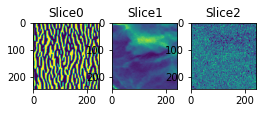

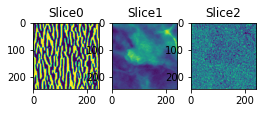

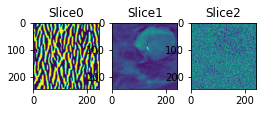

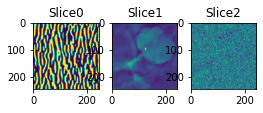

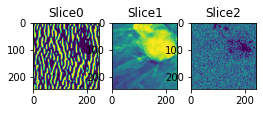

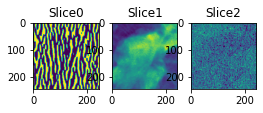

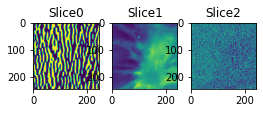

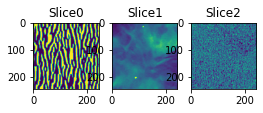

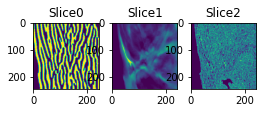

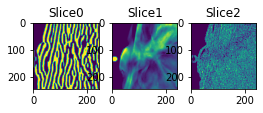

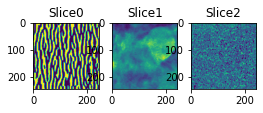

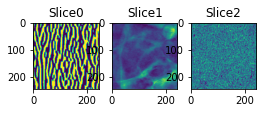

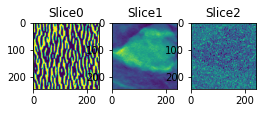

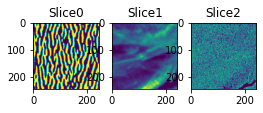

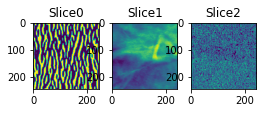

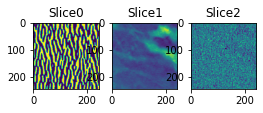

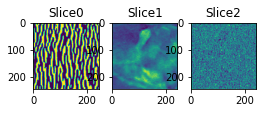

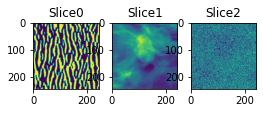

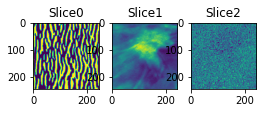

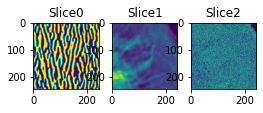

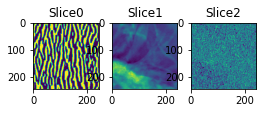

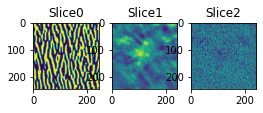

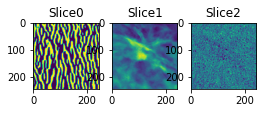

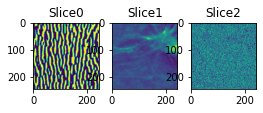

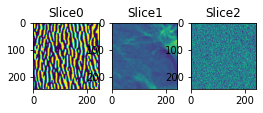

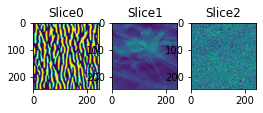

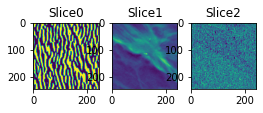

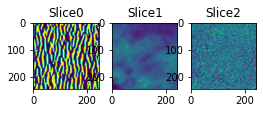

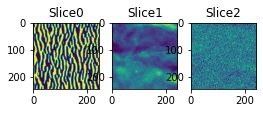

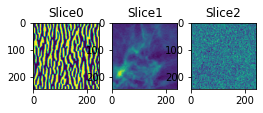

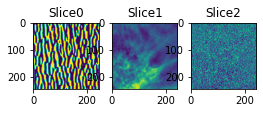

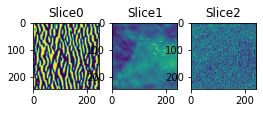

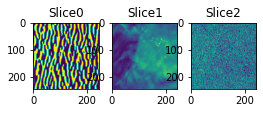

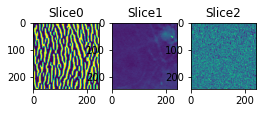

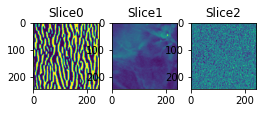

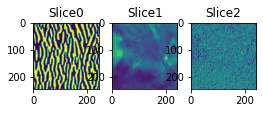

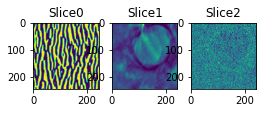

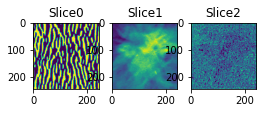

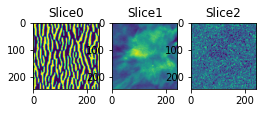

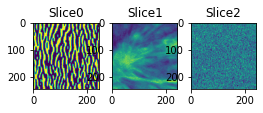

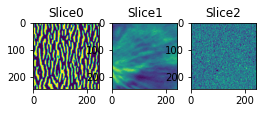

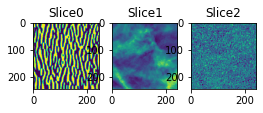

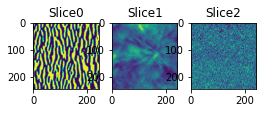

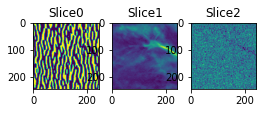

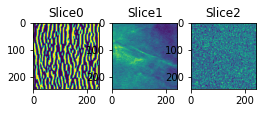

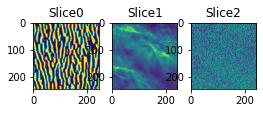

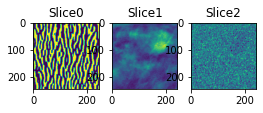

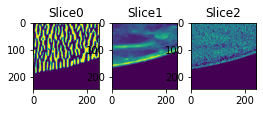

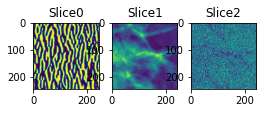

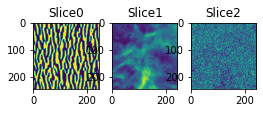

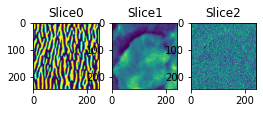

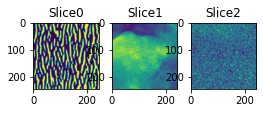

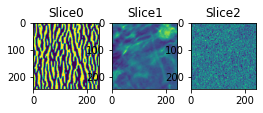

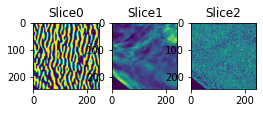

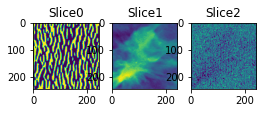

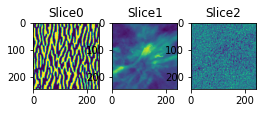

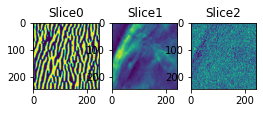

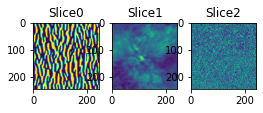

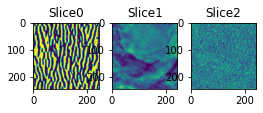

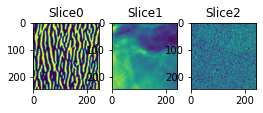

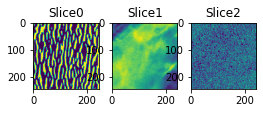

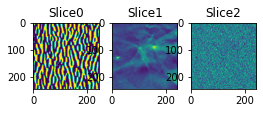

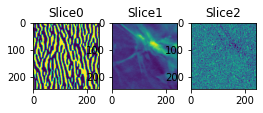

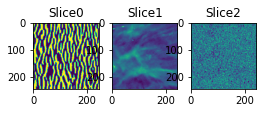

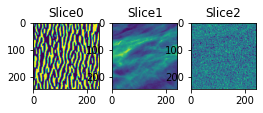

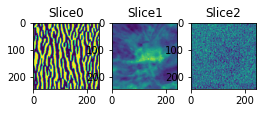

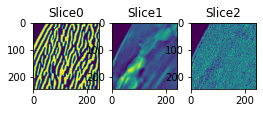

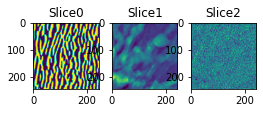

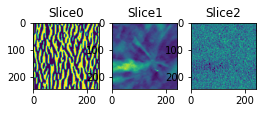

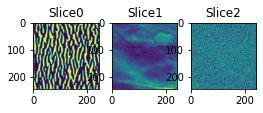

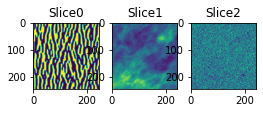

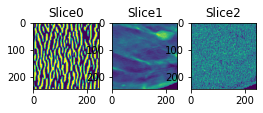

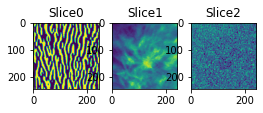

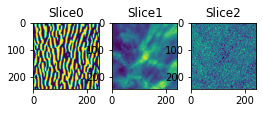

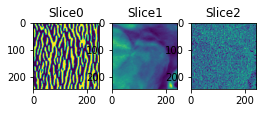

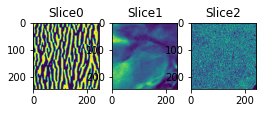

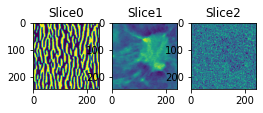

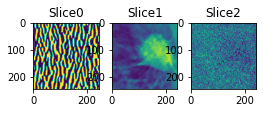

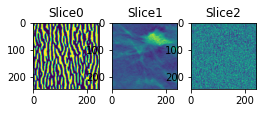

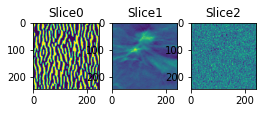

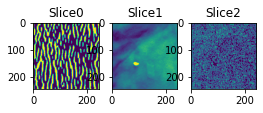

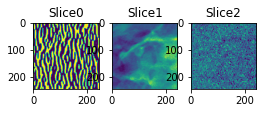

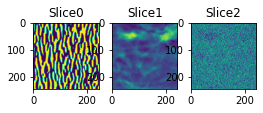

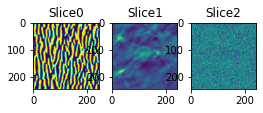

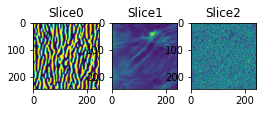

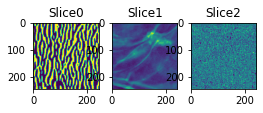

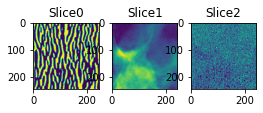

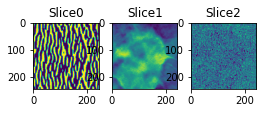

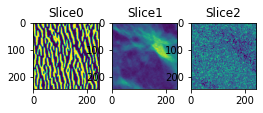

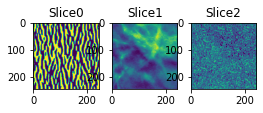

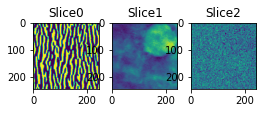

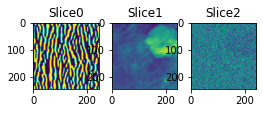

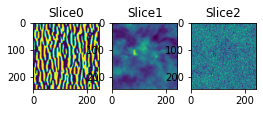

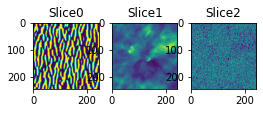

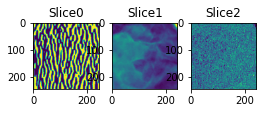

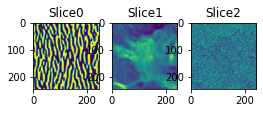

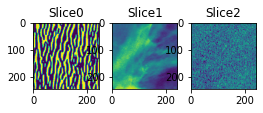

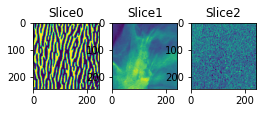

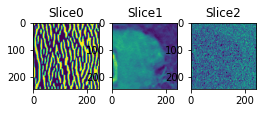

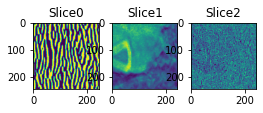

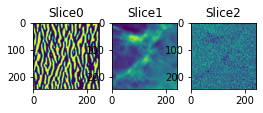

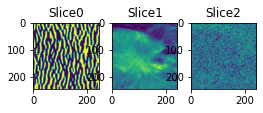

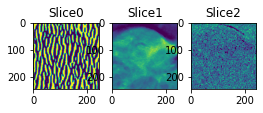

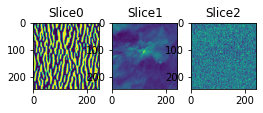

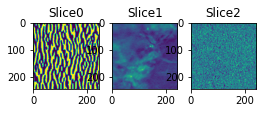

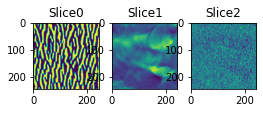

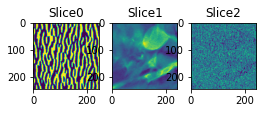

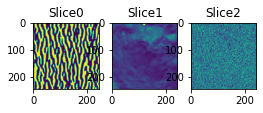

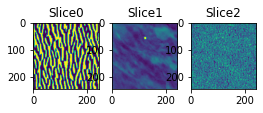

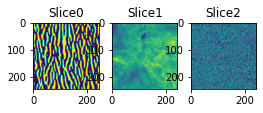

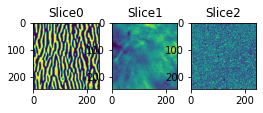

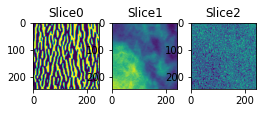

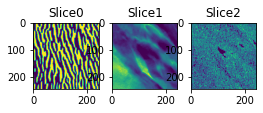

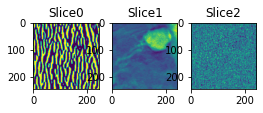

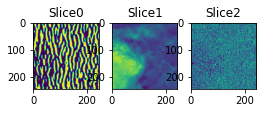

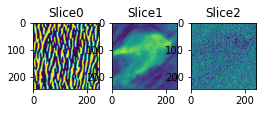

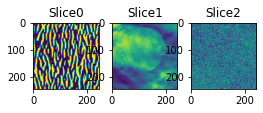

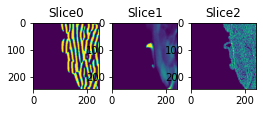

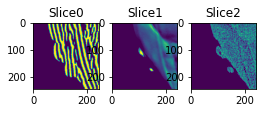

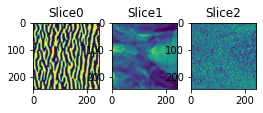

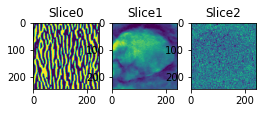

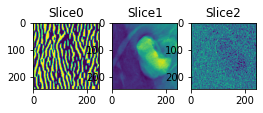

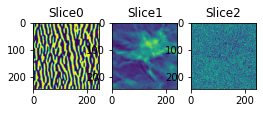

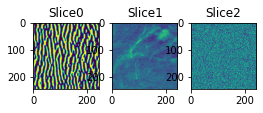

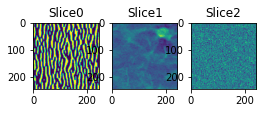

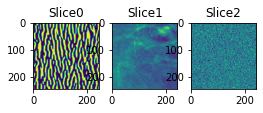

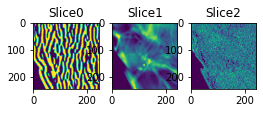

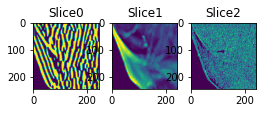

In [10]:
####################################################
# GENERATE BENIGN AND CANCER PATCHES
####################################################
use_augments = 0  #Disable additional augmented data

if (create_cancer_patches == 1):
    raw_files = os.listdir(data_dir)
    print('found #files: ',len(raw_files))

    #check to see if output directories are present
    for ii in (patch_cancer_dir ,patch_benign_dir):
        if (os.path.exists(ii)):
            print('Existing directory: ',ii)
        else:
            os.mkdir(ii)

    start_point  = -1
    patch_x = 244
    patch_y = 244
    for counter,filename in enumerate(raw_files):
        if (counter < start_point):
            continue
        
        #load full array
        full_filename = os.path.join(data_dir,filename)
        if (('Benign' in filename) or ('Cancer' in filename)): # or ('Actionable' in filename)): 
            #only want to run on benign/cancer/actionable labels   
            img_data = pickle.load( open( full_filename, "rb" ) )
            dims = np.shape(img_data)
            #select what type of image for filename creation
            if ('Benign' in filename):
                name_type = 0 #benign
            elif ('Actionable' in filename):
                print('Went into Actionable, but should not have been here')
                continue
                name_type = 1
            else:
                name_type = 2 #cancer
        else:
            #print('SKIPPING non-Annotated file')
            continue

        text_tokens = filename.split(sep='_')
        #format should be MM-DD-YYYY-DBT-S#####-~
        patient_id = text_tokens[0]
        study_id = text_tokens[1]
        view_id = text_tokens[2]



        box_info = get_ROI(patient_id, study_id,view_id, boxes_rows)
        slice_selection = int(box_info[0][0])
        x_corner_box = int(box_info[0][1])
        y_corner_box = int(box_info[0][2])
        x_width = int(box_info[0][3])
        y_height = int(box_info[0][4])

        num_slices, num_rows, num_cols = np.shape(img_data)



        #
        # Create patches, with a random set chosen from the annotation area. For 
        # cases where Normal greatly outnumbers the other classes, toggle the random
        # patches off
        #
        cancer_random_patches = 0 #turn off or on 

        if (cancer_random_patches == 1):
            num_cancer_patches = 5 #chosen number of random patches to make
        else:
            num_cancer_patches = 1



        for ii in range(0,num_cancer_patches):
            #make X random patch locations


            if (cancer_random_patches == 0): #Don't use random patches
                # just pass in the annotation corners
                y_corner = y_corner_box
                x_corner = x_corner_box

                output_fn = os.path.splitext(filename)[0]+'_s' + str(slice_selection) + \
                    '_cx' + str(x_corner) + '_cy' + \
                    str(y_corner) + '_' + str(patch_x) + '_' + str(patch_y) + '.pickle'
                if (name_type == 0): #benign
                    img_file_pickle_test = os.path.join(patch_benign_dir,output_fn)
                #elif (name_type == 1): #Actionable
                #    img_file_pickle_test = os.path.join(patch_actionable_dir,output_fn)            
                elif (name_type == 2): #cancer
                    img_file_pickle_test = os.path.join(patch_cancer_dir,output_fn)
                else:
                    print('Extra category found. Continue past')
                    continue

                #test to see if image already in directory
                if (os.path.exists(img_file_pickle_test)):
                    #skip this one, as it's already done
                    print('---> File already converted')
                    continue
            else:
                #make augmented boxes of random patches
                y_corner, _, x_corner, _ = randomize_patches(num_slices,
                                                             num_rows, num_cols,
                                                             slice_selection,
                                                             x_corner_box,
                                                             y_corner_box, x_width,y_height)


            #check to see if our patch size doesn't go past boundary
            if (x_corner <0):
                #don't allow and set to 0
                x_corner =0
                print('!!!! x_corner < 0. Setting to 0')

            if (y_corner < 0):
                #don't allow and set to 0
                y_corner = 0
                print('!!!! y_corner < 0. Setting to 0')

            if  ((x_corner + patch_x)> dims[2]):
                diff = (x_corner + patch_x) - dims[2]
                x_corner = x_corner - diff
                print('adjusting x limits of ', filename, x_corner)
            
            if  ((y_corner + patch_y)> dims[1]):
                diff = (y_corner + patch_y) - dims[1]
                y_corner = y_corner - diff
                print('adjusting y limits of ', filename, y_corner)


            #check to see if this given box size is smaller than our model patch size
            if ((x_width > patch_x) or (y_height > patch_y)):
                print('!! Model x Patch size smaller than annotation')
            if ((x_width < patch_x) or (y_height < patch_y)):
                print('!! Model y Patch size larger than annotation')

            #enforce patch sizing, since this was used earlier to select adjusted corner
            #values
            x_width = patch_x
            y_height = patch_y


            if (slice_selection <1):
                print('!!!! ANNOTATION TOO CLOSE TO SLICE BORDER!!!---SKIP')
                continue
            else:
                if (use_glcm_patches == 1):
                    print('ERROR!!! GLCM enabled')
                    stop()
                else:
                    print('counter is at', counter)
                    image_patch = np.zeros([3,patch_y,patch_x])
                    patch_img = img_data[slice_selection-1:slice_selection+2,
                                        y_corner:y_corner+y_height,
                                        x_corner:x_corner+x_width]

                    
                    filt_real, filt_imag=calc_Gabor(patch_img[1,:,:], frequency=gfrequency1,theta=theta)
                    image_patch[0,:,:] = filt_real
                    image_patch[1,:,:] = patch_img[1,:,:]
                    filt_real, filt_imag=calc_Gabor(patch_img[2,:,:], frequency=gfrequency2,theta=theta)
                    image_patch[2,:,:] =  filt_real
                    #patch_img = img_data[slice_selection-1:slice_selection+2,
                    #                    y_corner:y_corner+y_height,
                    #                    x_corner:x_corner+x_width]

            
            #check for empty image, before normalization occurs
            if (np.mean(patch_img) <1):
                plt.figure()
                plt.imshow(patch_img[1,:,:])
                plt.colorbar()
                plt.title('MEAN < 1')
                print('!!!!!!! BAD IMAGE!!!!! Skipping')
                continue


            #save patch to a file
            output_fn = os.path.splitext(filename)[0]+'_s' + str(slice_selection) + \
                '_cx' + str(x_corner) + '_cy' + \
                str(y_corner) + '_' + str(patch_x) + '_' + str(patch_y) + '.pickle'

            ####################################################################
            # Choose augmentation views to create
            ####################################################################
            if (('rmlo' in output_fn) or ('lmlo' in output_fn)):
                #R/L views should only have the Horizontal flip augment
                flip_on = 1
                rot180_on = 1
                rot90_on = 0
                rot270_on = 0
            else: #rcc/lcc
                flip_on = 1
                rot180_on = 1
                rot90_on = 0
                rot270_on = 0

            if ('Benign' in filename):
                img_file_pickle = os.path.join(patch_benign_dir,output_fn)
                pickle.dump(patch_img, open( img_file_pickle, "wb" ),protocol=5 )

                print('image size going into augment: ', np.shape(patch_img))
                if (use_glcm_patches == 1):

                    create_augmented_data(patch_img,img_file_pickle,patch_benign_dir,
                                        flip = flip_on,rot90=rot90_on,
                                        rot180=rot180_on,rot270=rot270_on,
                                        use_glcm =1,use_gabor =0, frequency0=gfrequency1,frequency1=gfrequency2)
                elif (use_gabor_patches == 1):
                    create_augmented_data(patch_img,img_file_pickle,patch_benign_dir,
                                        flip = flip_on,rot90=rot90_on,
                                        rot180=rot180_on,rot270=rot270_on,
                                        use_glcm =0,use_gabor =1, frequency0=gfrequency1,frequency1=gfrequency2,theta=theta)                
                else:
                    create_augmented_data(patch_img,img_file_pickle,patch_benign_dir,
                                        flip = flip_on,rot90=rot90_on,
                                        rot180=rot180_on,rot270=rot270_on)



            elif ('Cancer' in filename):
                img_file_pickle = os.path.join(patch_cancer_dir,output_fn)
                pickle.dump(patch_img, open( img_file_pickle, "wb" ),protocol=5 )

                print('image size going into augment: ', np.shape(patch_img))
                #AUGMENT CANCER SET WITH ADDITIONAL IMAGES
                if (use_glcm_patches == 1):

                    create_augmented_data(patch_img,img_file_pickle,patch_cancer_dir,
                                        flip = flip_on,rot90=rot90_on,
                                        rot180=rot180_on,rot270=rot270_on, 
                                        use_glcm = 1)    
                elif (use_gabor_patches == 1):
                    create_augmented_data(patch_img,img_file_pickle,patch_benign_dir,
                                        flip = flip_on,rot90=rot90_on,
                                        rot180=rot180_on,rot270=rot270_on,
                                        use_glcm =0,use_gabor =1, frequency0=gfrequency1,frequency1=gfrequency2,theta=theta) 
                else:
                    create_augmented_data(patch_img,img_file_pickle,patch_cancer_dir,
                                        flip = flip_on,rot90=rot90_on,
                                        rot180=rot180_on,rot270=rot270_on)
            else:
                #how did you get here??
                print('!!!!! Non-Benign/Cancer passed through!!!!!!')


            if (counter%100==0):
                print('shape of return is ', counter, np.shape(patch_img))
                #plt.figure()
                #plt.imshow(patch_img[1,:,:])
                #plt.colorbar()

            del patch_img
        del img_data
            #else:
            #    break

print('Completed writing patches')


In [ ]:
print(type(patch_img[0,1,1]))
data = np.uint16(patch_img)
np.shape(data)
plt.figure()
plt.imshow(data[1,:,:])
plt.colorbar()
print(type(data))
a = data[1,1,1]
print(type(a))

In [ ]:
!ls  '/content/gdrive/My Drive/DBT_WORKSPACE/TRAINING_PATCHES/NORMAL/' -lart |wc -l 

for counter,filename in enumerate(raw_files):
    if (counter < start_point):
        continue
    
    #load full array
    full_filename = os.path.join(data_dir,filename)
    if ('Benign' in filename): #(('Benign' in filename) or ('Cancer' in filename)): 
        #only want to run on normal/actionable labels   
        pass



'''
print(np.mean(patch_img))
plt.figure()
plt.imshow(img_data[slice_selection,:,:])
plt.colorbar()

print(x_corner, y_corner)
plt.figure()
plt.imshow(img_data[slice_selection, y_corner-20:y_corner+244,x_corner-50:x_corner+244])
'''

In [ ]:
cancer_files = os.listdir(patch_cancer_dir)
for counter, ii in enumerate(cancer_files):
    fname = os.path.join(patch_cancer_dir,ii)
    pdata = pickle.load( open( fname, "rb" ) )
    
    plt.figure()
    plt.imshow(pdata[1,:,:])
    plt.colorbar()   
    plt.title(fname)
print('processed %f files', counter)

In [ ]:
benign_files = os.listdir(patch_benign_dir)
for counter, ii in enumerate(benign_files):
    fname = os.path.join(patch_benign_dir,ii)
    pdata = pickle.load( open( fname, "rb" ) )
    
    plt.figure()
    plt.imshow(pdata[1,:,:])
    plt.colorbar()   
    plt.title(fname)
print('processed %f files', counter)

In [ ]:
file = os.path.join(data_dir,'DBT-P02750_DBT-S00905_rmlo_Benign.pickle')
pdata = pickle.load( open( file, "rb" ) )

plt.figure()
plt.imshow(pdata[1,:,:])
plt.colorbar()   

print(np.shape(pdata))

In [ ]:
#
# Choose valid patch size for Normal images
#

raw_files = os.listdir(data_dir)
print('found #files: ',len(raw_files))

if (1):
    #create fake patches for now
    patch_dict = {}
    for counter,filename in enumerate(raw_files):
        #load full array
        full_filename = os.path.join(data_dir,filename)
        img_data = pickle.load( open( full_filename, "rb" ) )

        #get a random slice
        number_slices = np.shape(img_data)[0]
        slice_selection = random.randint(0, number_slices-1)
        print('slice chosen is ',slice_selection)
        slice_data = img_data[slice_selection,:,:]

        # convert the grayscale image to binary image
        #look for anything >1 and assign that a 1 value. Expectation is that 
        #any area without attenuation will have 0 value -- adjust the lower val
        #if blurred areas need to be brought in. Last 0 is just the default
        #threshold type
        ret,thresh = cv2.threshold(slice_data,1,1,0)

        
        # calculate moments of binary image
        M = cv2.moments(thresh)
        # calculate x,y coordinate of center
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
        print('center is ', center_x,center_y)

        patch_x = 244
        patch_y = 244
        # create a patch centered at the centroid location
        patch_lr = center_x-int(patch_x/2),center_x+int(patch_x/2)
        patch_tb = center_y-int(patch_y/2),center_y+int(patch_y/2)
#        indices = np.where(slice_data!= [0])
#        coordinates = zip(indices[0], indices[1])


        plt.figure()
        plt.imshow(thresh,cmap='bone') #img_data[slice_selection,:,:],cmap='bone')
        plt.text(center_x,center_y,'.')
        plt.text(patch_lr[0],patch_tb[0],'O')
        plt.colorbar()


        #### Draw annotation box
        xcorner = int(patch_lr[0])
        ycorner = int(patch_tb[0])
        xwidth = int(244)
        yheight = int(244)
        
        rect = patches.Rectangle((xcorner,ycorner),xwidth,yheight,linewidth=2,edgecolor='r',facecolor='none')
        # Get the current reference
        ax = plt.gca()
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.show()
        ###



        #patch_data = img_data[0:3,:,:]
        #patch_dict[counter]= patch_data
        #print(full_filename,np.shape(patch_data))



        if (counter >= 0):
            break


In [ ]:
iter(coordinates,3)